In [1]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [2]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer,AutoTokenizer
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve, auc,f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [23]:
model = AutoModelForSequenceClassification.from_pretrained("voidism/diffcse-bert-base-uncased-trans", num_labels=1)
metric = evaluate.load("accuracy")
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

loading configuration file config.json from cache at C:\Users\Nikita/.cache\huggingface\hub\models--voidism--diffcse-bert-base-uncased-trans\snapshots\77046440b79536bb8d37842cf86034f69a8577bd\config.json
Model config BertConfig {
  "_name_or_path": "voidism/diffcse-bert-base-uncased-trans",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin fr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at voidism/diffcse-bert-base-uncased-trans and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [4]:
dataset_test = pd.read_parquet(r'test_result_roft.parquet', engine='fastparquet')
dataset_test

,model,text,label
0,finetuned,HOW TO MAKE: Mango-Glazed Turkey Breast\nIngre...,0
1,davinci,"""Is she for real?That purse does *not* go with...",0
2,davinci,I think it was the waiting that really got to ...,0
3,gpt2-xl,New Yorkers have an amazing knack of creating ...,0
4,gpt2-xl,HOW TO MAKE: Easy Chicken Pot Pie\nIngredients...,0
...,...,...,...
6899,gpt2-xl,HOW TO MAKE: Gibna With Tamatum or Cheese With...,0
6900,finetuned,HOW TO MAKE: Awesome Easy Marinade for Meat or...,0
6901,ctrl-nocode,"""Fifth Annual Message"" by President Theodore R...",0
6902,ctrl-Politics,"""Statement at the International American Confe...",0


In [5]:
dataset_train = pd.read_parquet(r'train_result_roft.parquet', engine='fastparquet')
dataset_train

,model,text,label
0,gpt2-xl,WHEN it comes to visions of what New Haven par...,0
1,finetuned,HOW TO MAKE: Breakfast Burrito (Like Mc Donald...,0
2,finetuned,HOW TO MAKE: Hot Banana Creme Brulee\nIngredie...,0
3,davinci,HOW TO MAKE: Howard's Failsafe Chicken Pasta\n...,0
4,finetuned,HOW TO MAKE: Roast Leg of Lamb with Red Wine S...,0
...,...,...,...
20705,davinci,"NATO's plan to airlift 100,000 desperate refug...",0
20706,gpt2-xl,Amer Hamedi's family has had a bakery in Tripo...,0
20707,finetuned,HOW TO MAKE: Orzo-Portabella Casserole\nIngred...,0
20708,ctrl-Politics,"""Statement on the Resumption of Bombing in Nor...",0


In [ ]:
dataset_test['label'] = dataset_test['label'].astype(float)
dataset_train['label'] = dataset_train['label'].astype(float)

In [7]:
dataset_train, dataset_eval, _, _ = train_test_split(dataset_train, dataset_train, test_size = 0.25,
                                                      shuffle = True, random_state = 42)

In [25]:
train_texts, train_labels = dataset_train['text'].tolist(),dataset_train['label'].tolist()
test_texts, test_labels = dataset_test['text'].tolist(),dataset_test['label'].tolist()
eval_texts, eval_labels = dataset_eval['text'].tolist(),dataset_eval['label'].tolist()

In [26]:
tokenizer = AutoTokenizer.from_pretrained("voidism/diffcse-bert-base-uncased-trans")
train_encodings = tokenizer(train_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
test_encodings = tokenizer(test_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
eval_encodings = tokenizer(eval_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\Nikita/.cache\huggingface\hub\models--voidism--diffcse-bert-base-uncased-trans\snapshots\77046440b79536bb8d37842cf86034f69a8577bd\config.json
Model config BertConfig {
  "_name_or_path": "voidism/diffcse-bert-base-uncased-trans",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt fro

In [27]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [28]:
train_dataset = MyDataset(train_encodings, train_labels)
test_dataset = MyDataset(test_encodings, test_labels)
eval_dataset = MyDataset(eval_encodings, eval_labels)


In [29]:
optim_param = ['adafactor', 'adamw_torch']

In [30]:
trainer = []
result = []
final_lst = []
for opt in optim_param:
    training_args.optim = opt
    trainer += [Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )]
for i in range(len(trainer)):
    trainer[i].train()
    lst = []
    result_test_pred = trainer[i].predict(eval_dataset)
    for i in range(len(eval_dataset.labels)):
        lst+=[scipy.special.expit(result_test_pred[0][i][0])]
    final_lst+=[lst]
    result += [pd.DataFrame(zip(eval_dataset.labels,lst),columns = ['true','pred'])]

***** Running training *****
  Num examples = 112
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42
  Number of trainable parameters = 109483009
C:\Users\Nikita\AppData\Local\Temp\ipykernel_21456\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.166597
2,No log,0.172608
3,No log,0.168298


***** Running Evaluation *****
  Num examples = 38
  Batch size = 8
***** Running Evaluation *****
  Num examples = 38
  Batch size = 8
***** Running Evaluation *****
  Num examples = 38
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 38
  Batch size = 8


***** Running training *****
  Num examples = 112
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42
  Number of trainable parameters = 109483009
C:\Users\Nikita\AppData\Local\Temp\ipykernel_21456\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.273462
2,No log,0.161201
3,No log,0.172955


***** Running Evaluation *****
  Num examples = 38
  Batch size = 8
***** Running Evaluation *****
  Num examples = 38
  Batch size = 8
***** Running Evaluation *****
  Num examples = 38
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 38
  Batch size = 8


In [31]:
res = []
for i in range(len(result)):
    res+=[roc_auc_score(result[i]['true'], result[i]['pred'])]
max_value = max(res)
max_index = res.index(max_value)
max_index

1

In [32]:
def find_model(optim_list,max_index):
    i = 0
    best_model = []
    for num_1,opt in enumerate(optim_list):
        print(i,opt)
        if i == max_index:
            best_model= [opt]
            return best_model
        else:
            i+=1
        

In [33]:
best_model = find_model(optim_param,max_index)
best_model

0 adafactor
1 adamw_torch


['adamw_torch']

In [34]:
result_test_pred = trainer[max_index].predict(test_dataset)

***** Running Prediction *****
  Num examples = 100
  Batch size = 8
C:\Users\Nikita\AppData\Local\Temp\ipykernel_21456\3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [35]:
lst = []
for i in range(len(test_dataset.labels)):
    lst+=[scipy.special.expit(result_test_pred[0][i][0])]
final_res = pd.DataFrame(zip(test_dataset.labels,lst),columns = ['true','pred'])
final_res

,true,pred
0,0.0,0.542843
1,0.0,0.483542
2,0.0,0.488709
3,0.0,0.521214
4,0.0,0.515936
...,...,...
95,0.0,0.494095
96,0.0,0.571792
97,0.0,0.539310
98,1.0,0.624080


In [36]:
def roc(test_result_old):   
    fpr, tpr, treshold = roc_curve(test_result_old['true'], test_result_old['pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         label=f'ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Совмещенные ROC-кривые')
    plt.legend(loc="lower right")
    plt.show()

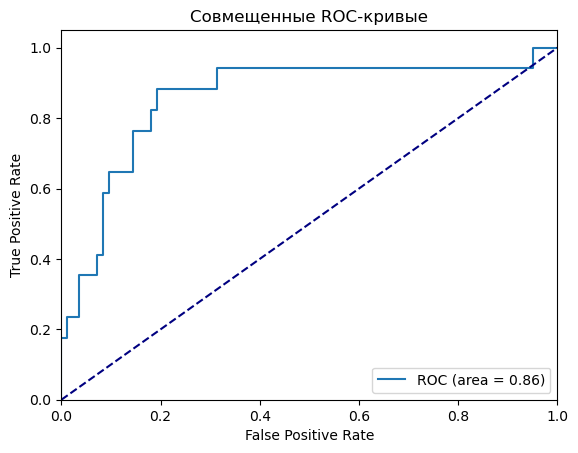

In [37]:
roc(final_res)

In [46]:
def confuns_matrix(train_rezalt_old):
    print(f'f1')
    print(f1_score(train_rezalt_old['true'].tolist(), [int(p>0.5) for p in train_rezalt_old['pred']], average='macro'))
    sns.heatmap(metrics.confusion_matrix(train_rezalt_old['true'],[int(p>0.5) for p in train_rezalt_old['pred']]),annot=True,cmap="Blues",square=True)
    plt.ylabel("label")
    plt.xlabel(f"")
    plt.title(f"Confusion matrix")
    plt.show()

f1
0.7481854540068138


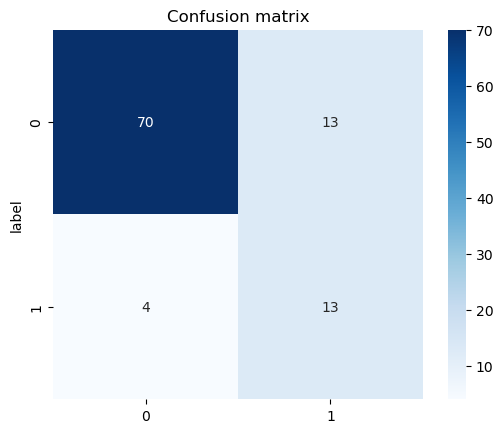

In [47]:
confuns_matrix(final_res)